# Figure 3
This figure does the following:
1. Demonstrates synthetic ripple detections in with real-time system
2. Compares Open Ephys and Spike Gadgets real-time systems

In [1]:
#imports
import numpy as np
import pandas as pd 
from tqdm import tqdm
import scipy.signal as signal #signal processing stuff (e.g. filters, hilbert transform, etc.)
import scipy
import scipy.stats as st
import struct
import os
import nelpy as nel #NELPY!
#I saved my online ripple detection filter taps and stuff in a file....gonna import this for all analysis
import imp
ripple_filtering = imp.load_source('ripple_filtering', '/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/DataAnalysisScripts/ripple_filtering.py')
#plotting!
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import nelpy.plotting as npl
import nelpy.io.trodes as neltro
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#make the svg
import svgutils.transform as sg
import sys
from IPython.display import SVG, display, Image

%matplotlib inline 

#Sampling rates
FS_system = 30000
FS = 3000 #decimated by 10
saveFigs = False

In [2]:
#for lfp
%matplotlib inline
mpl.rcdefaults()
sns.set(rc={'font.family': 'sans-serif','figure.figsize': (12, 4),'lines.linewidth': 1, 'font.size': 18, 'axes.labelsize': 16, 'axes.titlesize':18, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')

In [2]:
#for distribution plots
mpl.rcdefaults()
sns.set(rc={'figure.figsize': (3, 3),'lines.linewidth': 1, 'font.size': 18, 
            'axes.labelsize': 16, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')

## Spike Gadgets

In [3]:
# file_loc = "/media/shayok/3TBData/Data/RippleDetectionAnalysis/paperData/syntheticRippleDetections_new/update2/syntheticSG.rec"
onlinethreshold = 571.6 #this was what was calculated on trodes and since we're doing the same filtering here the value will be the same

### Fitlering the actual data that was run through

In [4]:
#Load up relevant lfp
#we want tetrode 1 channel 1, lowpass filtered, and decimated via Trodes!
# asa = neltro.load_wideband_lfp_rec(file_loc,\
#                                    "/home/shayok/Documents/Code/trodes/", channel = [1], tetrode = [1],\
#                                    decimation_factor = 1, trodes_style_decimation=True,\
#                                    delete_files=False,)
asa = nel.load_pkl("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure3/Figure3SpikeGadgets_offlinesignal.pkl",zip=False).asa

smoothed_envelope, rippleData = ripple_filtering.rippleBandFilter(asa.ydata[0], asa.time, FS=asa.fs)
asa.add_signal(nel.utils.signal_envelope1D(nel.filtering.ripple_band_filter(asa,)),label='Enveloped')
threshold = (asa[0,1].mean())+(3*asa[0,1].std())
offline_analysis_signals = asa
asa,asa.labels,asa.fs

(<AnalogSignalArray at 0x7f6394179fd0: 2 signals> for a total of 15:10:049 minutes,
 array(['t1c1', 'Enveloped'], 
       dtype='<U9'),
 3000.0)

### Offline Detections

In [5]:
cowy = asa[0,1]
#ripple detection across channels!
ripple_epochs = []
for i,cow in enumerate(cowy.signals):
    #find ripples!
    ripple_bounds, ripple_maxes, ripple_events = \
                                nel.utils.get_events_boundaries(cow.ydata, \
                                PrimaryThreshold = threshold,\
                                minThresholdLength = 0.015, ds=1/cow.fs)
    #ripple bounds stored as epoch arrays
    ripple_epochs.append(nel.EpochArray((ripple_bounds/cow.fs)+cow.time[0]))

In [6]:
len(ripple_epochs)

1

### Online Detections

In [8]:
# channels = neltro.load_digital_channel_nums(file_loc, verbose = True)

Channel in Array 1
Channel in Array 2
Channel in Array 3
Channel in Array 4
Channel in Array 5
Channel in Array 6
Channel in Array 7
Channel in Array 8
Channel in Array 9
Channel in Array 10
Channel in Array 11
Channel in Array 12
Channel in Array 13
Channel in Array 14
Channel in Array 15
Channel in Array 16


In [9]:
# digital_in = neltro.load_dio_rec(file_loc,"/home/shayok/Documents/Code/trodes/",channel=channels,data_already_extracted=False, verbose=False)

In [10]:
# [print(x) for x in digital_in]

[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0)]
[(4442238, 0) (4662549, 1) (4662557, 0) ..., (31009243, 0) (31061535, 1)
 (31061543, 0)]
[(4442238, 0)]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [11]:
# digital_in = np.asarray(digital_in[14])

In [7]:
digital_in = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure3/Figure3Digital.npz")['digital_inSG']

In [8]:
digital_in

array([(4442238, 0), (4662549, 1), (4662557, 0), ..., (31009243, 0),
       (31061535, 1), (31061543, 0)], 
      dtype=[('time', '<u4'), ('dio', 'u1')])

In [9]:
online_detections = digital_in['time'][np.where(digital_in['dio']>0)]/30000

In [10]:
online_detections

array([  155.4183    ,   157.16083333,   158.9553    ,   160.70393333,
         162.46303333,   164.22413333,   165.98403333,   167.7594    ,
         169.51213333,   171.28126667,   173.03816667,   174.81573333,
         176.56633333,   178.3299    ,   180.08903333,   181.8575    ,
         183.61586667,   185.38046667,   187.15093333,   188.90883333,
         190.67623333,   192.43933333,   194.21433333,   195.97023333,
         197.72053333,   199.49523333,   201.23806667,   203.029     ,
         204.7828    ,   206.55523333,   208.30443333,   210.05963333,
         211.8428    ,   213.61193333,   215.34883333,   217.1221    ,
         218.8978    ,   220.66113333,   222.42613333,   224.17583333,
         225.94393333,   227.69516667,   229.46886667,   231.23426667,
         232.99446667,   234.76863333,   236.52516667,   238.29186667,
         240.05653333,   241.81206667,   243.57796667,   245.34093333,
         247.11433333,   248.87086667,   250.6235    ,   252.38616667,
      

### Simulated Detections

In [11]:
# asa = neltro.load_wideband_lfp_rec(file_loc,\
#                                    "/home/shayok/Documents/Code/trodes/", channel = [1], tetrode = [1],\
#                                    decimation_factor = 1, trodes_style_decimation=True, trodes_lowpass_filter_freq=400, trodes_highpass_filter_freq=0,\
#                                    delete_files=False,)
asa = nel.load_pkl("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure3/Figure3SpikeGadgets_onlinesignal.pkl",zip=False).asa

In [12]:
#simulated detections smoothing!
smoothed_envelope_simulated, _ = ripple_filtering.rippleBandFilterSimulated(asa[0,0].ydata/0.195,asa.time, asa.fs, bpFilterTaps=ripple_filtering.bandpassFilterTaps, lpFilterTaps=ripple_filtering.lowpassFilterTaps)
smoothed_envelope_simulated = np.squeeze(smoothed_envelope_simulated)

In [13]:
#sim detections
blocklength = 600
ripple_indices = np.zeros(smoothed_envelope_simulated.shape)
i = 0
while i < len(smoothed_envelope_simulated):
    if(smoothed_envelope_simulated[i] > onlinethreshold):
        ripple_indices[i] = 1
        ripple_indices[i+1:blocklength] = 0
        i += blocklength
    else:
        ripple_indices[i] = 0
        i += 1 
simdetections = asa.time[np.where(ripple_indices>0)]

### Calculate TPR, FPR, Detect Lats, 

In [14]:
#ripple evals: tpr, fpr, detect lat

i=0
j=0
detectionindex = 0
simulated_detection_latencies = []
whichonessimulated = []
whichripple = []
while i < len(simdetections) and j<len(ripple_epochs[0]):
        #accurate detections
        if simdetections[i] > ripple_epochs[0].time[j][0] and simdetections[i] < ripple_epochs[0].time[j][1]:
            simulated_detection_latencies.append(simdetections[i]-ripple_epochs[0].time[j][0])
            whichripple.append(ripple_epochs[0].time[j][0])
            whichonessimulated.append(detectionindex)
            detectionindex+=1
            i+=1
            j+=1
        #false detection
        elif simdetections[i] < ripple_epochs[0].time[j][0]:
            i+=1
        #missed detection
        elif simdetections[i] > ripple_epochs[0].time[j][1]:
            j+=1
            
simulated_detection_latencies = np.asarray(simulated_detection_latencies)


j=0
i=0
truepositives = 0
falsepositives = 0
online_detection_latencies = []
whichonesonline = []
interesting = []
closedLoopLats = []
while i < len(online_detections) and j<len(ripple_epochs[0]):
        #accurate detection
        if online_detections[i] > ripple_epochs[0].time[j][0] and online_detections[i] < ripple_epochs[0].time[j][1]:
            online_detection_latencies.append(online_detections[i]-ripple_epochs[0].time[j][0])
            if ripple_epochs[0].time[j][0] in whichripple:
                whichonesonline.append(truepositives)
                closedLoopLats.append(online_detection_latencies[-1] - simulated_detection_latencies[truepositives])
            else:
                interesting.append(ripple_epochs[0].time[j][0])
            truepositives+=1
            i+=1
            j+=1
        #false detection
        elif online_detections[i] < ripple_epochs[0].time[j][0]:
            i+=1
            falsepositives+=1
        #missed detection
        elif online_detections[i] > ripple_epochs[0].time[j][1]:
            j+=1
        #This is not accounting for a ripple detection before the first true positive
        #detection. This is fine in this controlled experiment since it won't happen.
        #The detection analysis for the in vivo data as well as the actual synthetic analysis
        #does indeed do this. Check the cpp code. 
tpr = truepositives*100/(len(ripple_epochs[0]))
fpr = falsepositives*100/len(ripple_epochs[0])
online_detection_latencies = np.asarray(online_detection_latencies)
print('online tpr, fpr ', tpr,fpr)

online tpr, fpr  99.79959919839679 3.2064128256513027


In [15]:
simulated_detection_latencies.shape, online_detection_latencies.shape

((498,), (498,))

In [16]:
simulated_detection_latencies[whichonessimulated].size, online_detection_latencies[whichonesonline].size

(498, 498)

498 detections out of 499 injected ripples...I was off by one ripple in terms of what I injected into the noise! :(

## Generate panel (b)

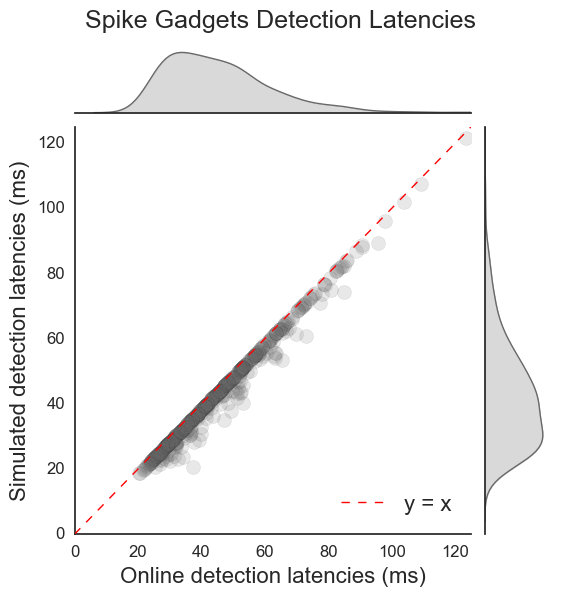

Average Detection Latency 45.43775100401541 ms
Simulated Average Detection Latency 42.79116465863569 ms
Median Detection Latency 42.1833333333268 ms
Simulated Median Detection Latency 39.99999999997783 ms
Average Closed Loop Latency 2.646586345379724 ms
Median Closed Loop Latency 1.8666666666149467 ms


In [17]:
saveFigs = True
mpl.rcdefaults()
sns.set(rc={'figure.figsize': (3, 3),'lines.linewidth': 1, 'font.size': 18, 
            'axes.labelsize': 16, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')

test = np.asarray([online_detection_latencies[whichonesonline]*1000, simulated_detection_latencies[whichonessimulated]*1000])
test = np.transpose(test)
x = np.arange(500)
y = x

df = pd.DataFrame(test, columns=["Online detection latencies (ms)","Simulated detection latencies (ms)"])

g = sns.JointGrid(x="Online detection latencies (ms)", y="Simulated detection latencies (ms)", data=df,xlim=[0,125],ylim=[0,125]) #setup grid
g.fig.suptitle("Spike Gadgets Detection Latencies",y=1.01)
g = g.plot_joint(plt.scatter, c='dimgray',alpha=0.15,s=100,zorder=1) #scatter plot
g = g.plot_marginals(sns.kdeplot, color='dimgray',shade=True) #distributions
g.ax_joint.plot(x,y, 'r--',label='y = x',zorder=3,c='red') #1 to 1 line

g.ax_joint.legend(loc='lower right')
if(saveFigs):
    g.savefig('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/scatter-sim-sg.svg')
    
plt.show()
    
print("Average Detection Latency {} ms".format(np.mean(online_detection_latencies[whichonesonline])*1000))
print("Simulated Average Detection Latency {} ms".format(np.mean(simulated_detection_latencies[whichonessimulated])*1000))
print("Median Detection Latency {} ms".format(np.median(online_detection_latencies[whichonesonline])*1000))
print("Simulated Median Detection Latency {} ms".format(np.median(simulated_detection_latencies[whichonessimulated])*1000))
print("Average Closed Loop Latency {} ms".format(np.mean(closedLoopLats)*1000))
print("Median Closed Loop Latency {} ms".format(np.median(closedLoopLats)*1000))

In [18]:
closedLoopLats = np.asarray(closedLoopLats)*1000

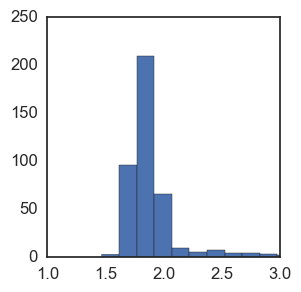

In [19]:
plt.hist(closedLoopLats,bins=100)
plt.xlim(1,3)
plt.show()

In [20]:
(np.asarray(np.where(closedLoopLats>1.5)).size-np.asarray(np.where(closedLoopLats>2.6)).size)/len(closedLoopLats)

0.8032128514056225

In [21]:
np.median(closedLoopLats)

1.8666666666149467

<b> Closed Loop Latency </b><br>
~80% data within 1.35 and 2.6 ms <br>
1.83 ms median 

## Generate panel (a)

/home/shayok/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
/home/shayok/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 


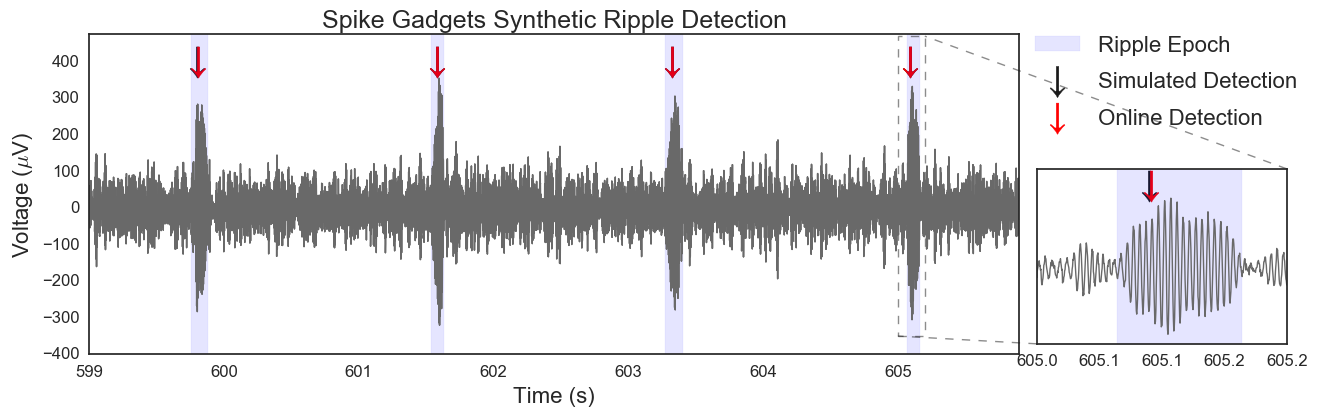

In [22]:
saveFigs = True

#for lfp
%matplotlib inline
mpl.rcdefaults()
sns.set(rc={'font.family': 'sans-serif','figure.figsize': (12, 4),'lines.linewidth': 1, 'font.size': 18, 'axes.labelsize': 16, 'axes.titlesize':18, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')


#Main Plot
ax = plt.gca()
ax.plot(offline_analysis_signals.time,offline_analysis_signals[0,0].ydata.squeeze(),color='dimgray',alpha=0.95) #LFP offline
ax.plot(offline_analysis_signals.time,offline_analysis_signals[0,0].ydata.squeeze(),color='dimgray',alpha=0.95) #LFP offline
npl.epochplot(ripple_epochs[0],color='blue',alpha=0.1,label="Ripple Epoch",hatch='') #Canonical Ripple Epoch
arrow = u'$\u2193$'
ax.scatter(simdetections, np.ones(simdetections.shape)*400,color="k",s=500,marker=arrow,label="Simulated Detection") #detection timestamp
ax.scatter(online_detections, np.ones(online_detections.shape)*400,color="red",s=500,marker=arrow,label="Online Detection") #detection timestamp
ax.set_xlim(599,605.9)
ax.set_ylim(-400,475)
ax.set_title("Spike Gadgets Synthetic Ripple Detection")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage ($\mu$V)")


#Inset
axins = inset_axes(parent_axes=ax,
                    width=2.5,
                    height=1.75,
                    loc=5,
                    bbox_to_anchor=(1.16, 0.345), 
                    bbox_transform=ax.figure.transFigure,
                    borderpad=2,
                  )

# axins = inset_axes(ax, 2,2 , loc=5,bbox_to_anchor=(1.10, 0.34),bbox_transform=ax.figure.transFigure) # no zoom
axins.plot(offline_analysis_signals.time,offline_analysis_signals[0,0].ydata.squeeze(),color='dimgray',alpha=1)
npl.epochplot(ripple_epochs[0],color='blue',alpha=0.1,label="Ripple Epoch",hatch="") #Canonical Ripple Epoch
axins.scatter(simdetections, np.ones(simdetections.shape)*390,color="k",s=500,marker=arrow,label="Simulated Detection") #detection timestamp
axins.scatter(online_detections, np.ones(online_detections.shape)*390,color="red",s=500,marker=arrow,label="Online Detection") #detection timestamp

#axis ticks and stuff
axins.get_xaxis().get_major_formatter().set_useOffset(False)
xrange = [500,700]
plt.xticks(np.arange(min(xrange),max(xrange),0.05))
plt.yticks(visible=False)
axins.set_ylim(-350,470)
axins.set_xlim(605,605.2)

#legend
leg = ax.legend(bbox_to_anchor=(1.32,1.06), loc=1, labelspacing=0.75)

#zoom 
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="k", lw=1, ls='--', alpha=0.5)

if(saveFigs):
    plt.savefig('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/detect-sim-zoom-sg.svg',bbox_inches='tight')

plt.show()

## Open Ephys

In [2]:
# filepath = "/media/shayok/3TBData/Data/RippleDetectionAnalysis/paperData/syntheticRippleDetections_new/update2/syntheticOE.rec"
onlinethreshold = 579.8

In [3]:
#Load up relevant lfp
#we want tetrode 1 channel 1, lowpass filtered, and decimated via Trodes!
# asa = neltro.load_wideband_lfp_rec(filepath,\
#                                    "/home/shayok/Documents/Code/trodes/", channel = [1], tetrode = [1],\
#                                    decimation_factor = 1, trodes_style_decimation=True,\
#                                    delete_files=False,)
asa = nel.load_pkl("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure3/Figure3OpenEphys_offlinesignal.pkl",zip=False).asa
smoothed_envelope, rippleData = ripple_filtering.rippleBandFilter(asa.ydata[0], asa.time, FS=asa.fs)
asa.add_signal(nel.utils.signal_envelope1D(nel.filtering.ripple_band_filter(asa,)),label='Enveloped')
asa,asa.labels,asa.fs
offline_analysis_signals = asa

In [4]:
threshold = (asa[0,1].mean())+(3*asa[0,1].std())

In [5]:
cowy = asa[0,1]
#ripple detection across channels!
ripple_epochs = []
for i,cow in enumerate(cowy.signals):
    #find ripples!
    ripple_bounds, ripple_maxes, ripple_events = \
                                nel.utils.get_events_boundaries(cow.ydata, \
                                PrimaryThreshold = threshold,\
                                minThresholdLength = 0.015, ds=1/cow.fs)
    #ripple bounds stored as epoch arrays
    ripple_epochs.append(nel.EpochArray((ripple_bounds/cow.fs)+cow.time[0]))

In [75]:
# channels = neltro.load_digital_channel_nums(filepath, verbose = True)
# digital_in = neltro.load_dio_rec(filepath,"/home/shayok/Documents/Code/trodes/",channel=channels,data_already_extracted=False, verbose=False)
# [print(x) for x in digital_in]

[( 8166720, 0) ( 8357986, 1) ( 8357993, 0) ..., (34705187, 0) (34757248, 1)
 (34757258, 0)]
[(8166720, 0)]
[(8166720, 0)]
[(8166720, 0)]
[(8166720, 0)]
[(8166720, 0)]
[(8166720, 0)]
[(8166720, 0)]


[None, None, None, None, None, None, None, None]

In [6]:
# digital_in = np.asarray(digital_in[0])
digital_in = np.load("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure3/Figure3Digital.npz")['digital_inOE']
online_detections = digital_in['time'][np.where(digital_in['dio']>0)]/30000

In [7]:
# asa = neltro.load_wideband_lfp_rec(filepath,\
#                                    "/home/shayok/Documents/Code/trodes/", channel = [1], tetrode = [1],\
#                                    decimation_factor = 1, trodes_style_decimation=True, trodes_lowpass_filter_freq=400, trodes_highpass_filter_freq=0,\
#                                    delete_files=False,)
asa = nel.load_pkl("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/paperData/figureData/Figure3/Figure3OpenEphys_onlinesignal.pkl",zip=False).asa

In [8]:
#simulated detections smoothing!
smoothed_envelope_simulated, _ = ripple_filtering.rippleBandFilterSimulated(asa[0,0].ydata/0.195,asa.time, asa.fs, bpFilterTaps=ripple_filtering.bandpassFilterTaps, lpFilterTaps=ripple_filtering.lowpassFilterTaps)
smoothed_envelope_simulated = np.squeeze(smoothed_envelope_simulated)

In [9]:
#sim detections
blocklength = 600
ripple_indices = np.zeros(smoothed_envelope_simulated.shape)
i = 0
while i < len(smoothed_envelope_simulated):
    if(smoothed_envelope_simulated[i] > onlinethreshold):
        ripple_indices[i] = 1
        ripple_indices[i+1:blocklength] = 0
        i += blocklength
    else:
        ripple_indices[i] = 0
        i += 1 
simdetections = asa.time[np.where(ripple_indices>0)]

In [10]:
#ripple evals: tpr, fpr, detect lat

i=0
j=0
detectionindex = 0
simulated_detection_latencies = []
whichonessimulated = []
whichripple = []
while i < len(simdetections) and j<len(ripple_epochs[0]):
        #accurate detections
        if simdetections[i] > ripple_epochs[0].time[j][0] and simdetections[i] < ripple_epochs[0].time[j][1]:
            simulated_detection_latencies.append(simdetections[i]-ripple_epochs[0].time[j][0])
            whichripple.append(ripple_epochs[0].time[j][0])
            whichonessimulated.append(detectionindex)
            detectionindex+=1
            i+=1
            j+=1
        #false detection
        elif simdetections[i] < ripple_epochs[0].time[j][0]:
            i+=1
        #missed detection
        elif simdetections[i] > ripple_epochs[0].time[j][1]:
            j+=1
            
simulated_detection_latencies = np.asarray(simulated_detection_latencies)


j=0
i=0
truepositives = 0
falsepositives = 0
online_detection_latencies = []
whichonesonline = []
interesting = []
closedLoopLats = []
while i < len(online_detections) and j<len(ripple_epochs[0]):
        #accurate detection
        if online_detections[i] > ripple_epochs[0].time[j][0] and online_detections[i] < ripple_epochs[0].time[j][1]:
            online_detection_latencies.append(online_detections[i]-ripple_epochs[0].time[j][0])
            if ripple_epochs[0].time[j][0] in whichripple:
                whichonesonline.append(truepositives)
                closedLoopLats.append(online_detection_latencies[-1] - simulated_detection_latencies[truepositives])
            else:
                interesting.append(ripple_epochs[0].time[j][0])
            truepositives+=1
            i+=1
            j+=1
        #false detection
        elif online_detections[i] < ripple_epochs[0].time[j][0]:
            i+=1
            falsepositives+=1
        #missed detection
        elif online_detections[i] > ripple_epochs[0].time[j][1]:
            j+=1
        #This is not accounting for a ripple detection before the first true positive
        #detection. This is fine in this controlled experiment since it won't happen.
        #The detection analysis for the in vivo data as well as the actual synthetic analysis
        #does indeed do this. Check the cpp code. 
tpr = truepositives*100/(len(ripple_epochs[0]))
fpr = falsepositives*100/len(ripple_epochs[0])
online_detection_latencies = np.asarray(online_detection_latencies)
print('online tpr, fpr ', tpr,fpr)

online tpr, fpr  99.79919678714859 6.224899598393574


## Generate panel (d)

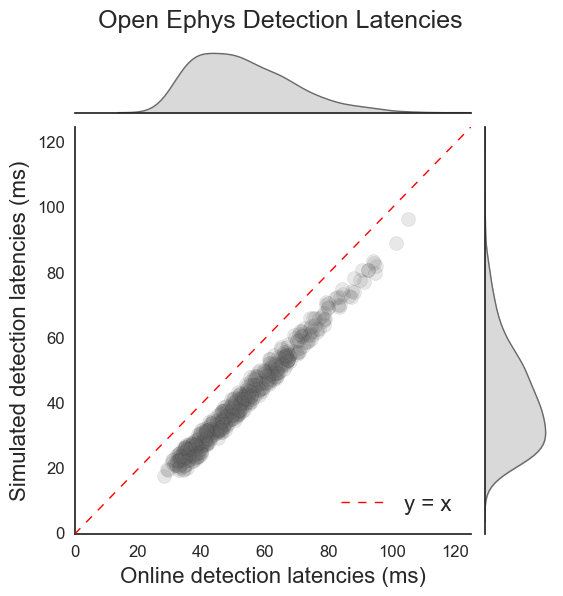

Average Detection Latency 53.31535881958333 ms
Simulated Average Detection Latency 41.6485580147541 ms
Median Detection Latency 51.13333333332548 ms
Simulated Median Detection Latency 38.99999999998727 ms
Average Closed Loop Latency 11.666800804829233 ms
Median Closed Loop Latency 11.700000000018917 ms


In [11]:
saveFigs = True
mpl.rcdefaults()
sns.set(rc={'figure.figsize': (3, 3),'lines.linewidth': 1, 'font.size': 18, 
            'axes.labelsize': 16, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')

test = np.asarray([online_detection_latencies[whichonesonline]*1000, simulated_detection_latencies[whichonessimulated]*1000])
test = np.transpose(test)
x = np.arange(500)
y = x

df = pd.DataFrame(test, columns=["Online detection latencies (ms)","Simulated detection latencies (ms)"])

g = sns.JointGrid(x="Online detection latencies (ms)", y="Simulated detection latencies (ms)", data=df,xlim=[0,125],ylim=[0,125]) #setup grid
g.fig.suptitle("Open Ephys Detection Latencies",y=1.01)
g = g.plot_joint(plt.scatter, c='dimgray',alpha=0.15,s=100,zorder=1) #scatter plot
g = g.plot_marginals(sns.kdeplot, color='dimgray',shade=True) #distributions
g.ax_joint.plot(x,y, 'r--',label='y = x',zorder=3,c='red') #1 to 1 line

g.ax_joint.legend(loc='lower right')
if(saveFigs):
    g.savefig('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/scatter-sim-oe.svg')
    
plt.show()
    
print("Average Detection Latency {} ms".format(np.mean(online_detection_latencies[whichonesonline])*1000))
print("Simulated Average Detection Latency {} ms".format(np.mean(simulated_detection_latencies[whichonessimulated])*1000))
print("Median Detection Latency {} ms".format(np.median(online_detection_latencies[whichonesonline])*1000))
print("Simulated Median Detection Latency {} ms".format(np.median(simulated_detection_latencies[whichonessimulated])*1000))
print("Average Closed Loop Latency {} ms".format(np.mean(closedLoopLats)*1000))
print("Median Closed Loop Latency {} ms".format(np.median(closedLoopLats)*1000))

In [12]:
closedLoopLats = np.asarray(closedLoopLats)*1000

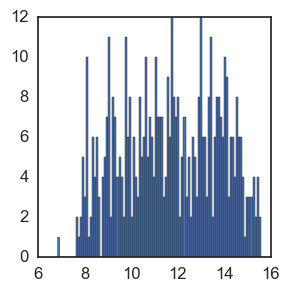

In [13]:
plt.hist(closedLoopLats,bins=100)
# plt.xlim(1,3)
plt.show()

In [14]:
(np.asarray(np.where(closedLoopLats>7.5)).size-np.asarray(np.where(closedLoopLats>13.8)).size)/len(closedLoopLats)

0.8008048289738431

In [15]:
np.median(closedLoopLats)

11.700000000018917

<b>Closed Loop Latency</b><br>
~80% closed loop latencies between 7.5 ms and 13.8 ms <br> 
~11.7 ms median latency

## Generate panel (c)

/home/shayok/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
/home/shayok/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 


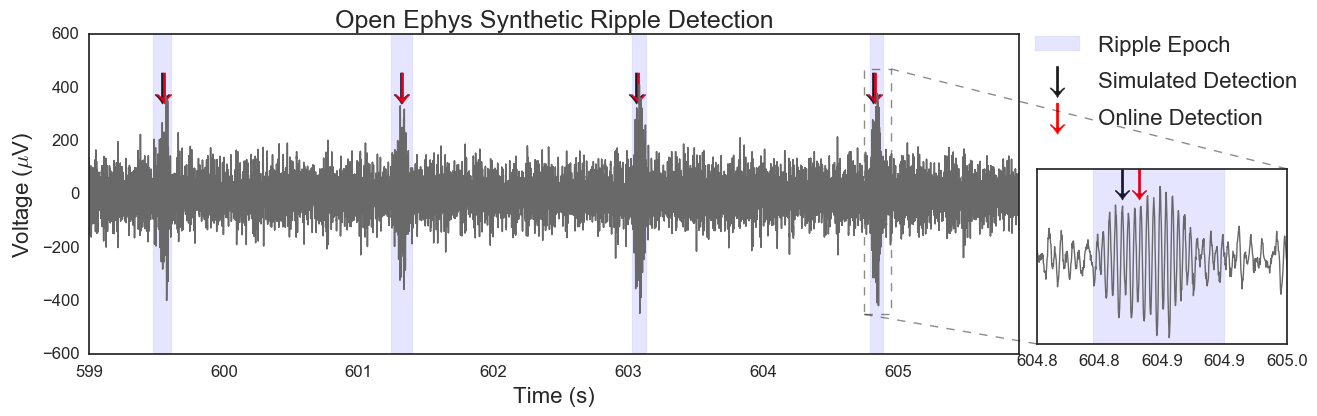

In [16]:
saveFigs = True

#for lfp
%matplotlib inline
mpl.rcdefaults()
sns.set(rc={'font.family': 'sans-serif','figure.figsize': (12, 4),'lines.linewidth': 1, 'font.size': 18, 'axes.labelsize': 16, 'axes.titlesize':18, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.set_color_codes(palette='deep')

#main plot
ax = plt.gca()
ax.plot(offline_analysis_signals.time,offline_analysis_signals[0,0].ydata.squeeze(),color='dimgray',alpha=0.95) #LFP offline
ax.plot(offline_analysis_signals.time,offline_analysis_signals[0,0].ydata.squeeze(),color='dimgray',alpha=0.95) #LFP offline
npl.epochplot(ripple_epochs[0],color='blue',alpha=0.1,label="Ripple Epoch",hatch='') #Canonical Ripple Epoch
arrow = u'$\u2193$'
plt.scatter(simdetections, np.ones(simdetections.shape)*400,color="k",s=500,marker=arrow,label="Simulated Detection") #detection timestamp
plt.scatter(online_detections, np.ones(online_detections.shape)*400,color="red",s=500,marker=arrow,label="Online Detection") #detection timestamp
ax.set_xlim(599,599+6.9)
ax.set_ylim(-600,600)
ax.set_title("Open Ephys Synthetic Ripple Detection")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage ($\mu$V)")

#legend
leg = ax.legend(bbox_to_anchor=(1.32,1.06), loc=1, labelspacing=0.75)

#Inset
axins = inset_axes(parent_axes=ax,
                    width=2.5,
                    height=1.75,
                    loc=5,
                    bbox_to_anchor=(1.16, 0.345), 
                    bbox_transform=ax.figure.transFigure,
                    borderpad=2,
                  )

# axins = inset_axes(ax, 2,2 , loc=5,bbox_to_anchor=(1.10, 0.34),bbox_transform=ax.figure.transFigure) # no zoom
axins.plot(offline_analysis_signals.time,offline_analysis_signals[0,0].ydata.squeeze(),color='dimgray',alpha=1)
npl.epochplot(ripple_epochs[0],color='blue',alpha=0.1,label="Ripple Epoch",hatch="") #Canonical Ripple Epoch
axins.scatter(simdetections, np.ones(simdetections.shape)*390,color="k",s=500,marker=arrow,label="Simulated Detection") #detection timestamp
axins.scatter(online_detections, np.ones(online_detections.shape)*390,color="red",s=500,marker=arrow,label="Online Detection") #detection timestamp

#axis ticks and stuff
axins.get_xaxis().get_major_formatter().set_useOffset(False)
xrange = [500,700]
plt.xticks(np.arange(min(xrange),max(xrange),0.05))
plt.yticks(visible=False)
axins.set_ylim(-450,470)
axins.set_xlim(604.75,604.95)



#zoom 
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="k", lw=1, ls='--', alpha=0.5)

if saveFigs:
    plt.savefig('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/detect-sim-zoom-oe.svg',bbox_inches='tight')

plt.show()

## Final Figure

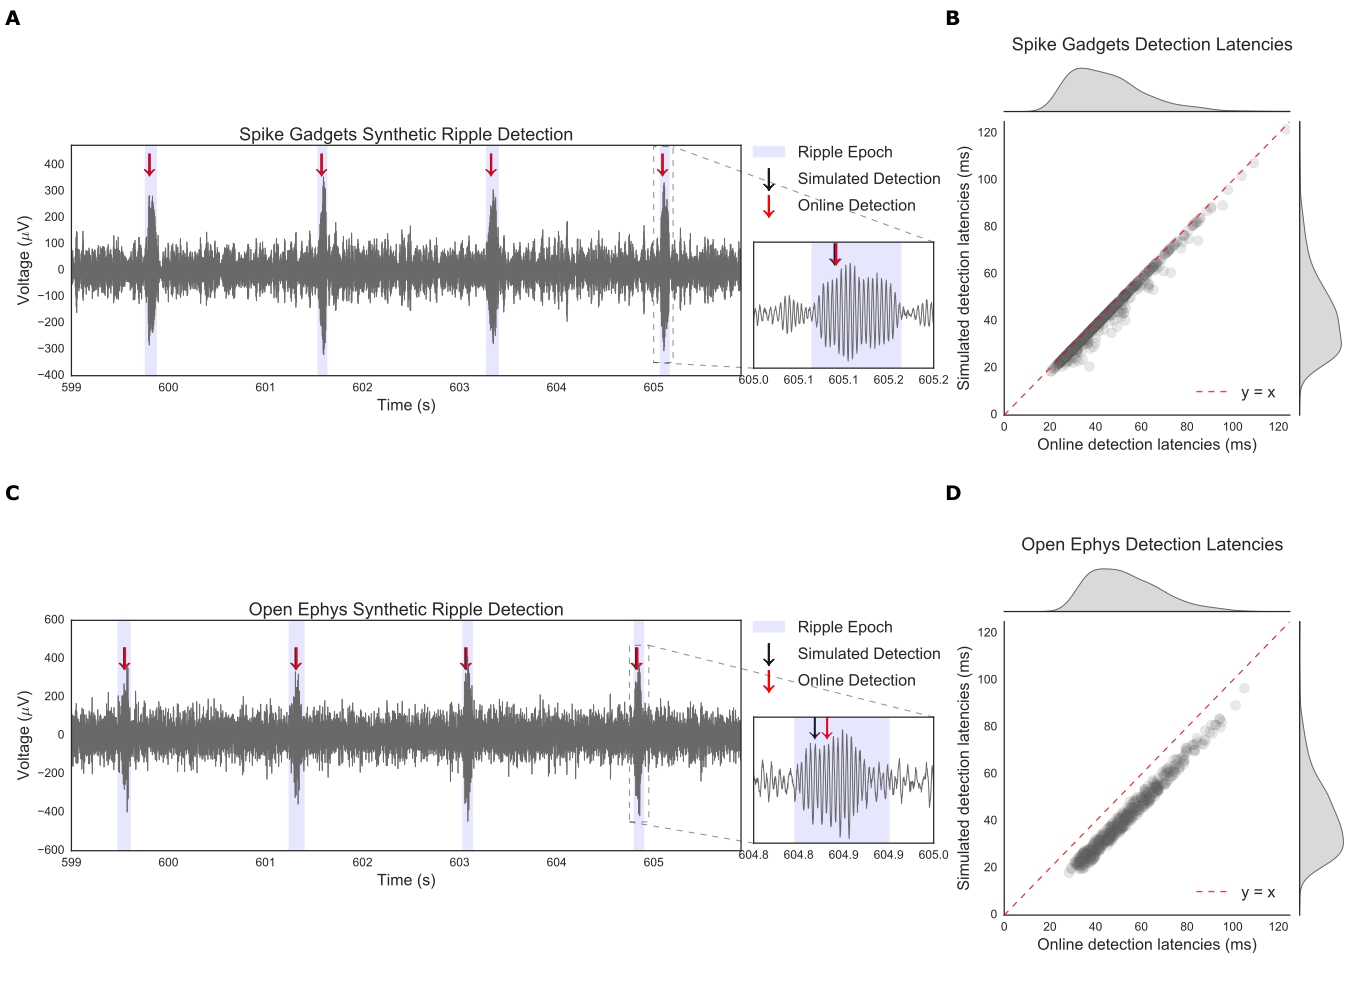

In [17]:
#create new SVG figure
fig = sg.SVGFigure("15in", "11in")

#load matplotlib-generated figures
fig1 = sg.fromfile("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/detect-sim-zoom-sg.svg")
fig4 = sg.fromfile('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/scatter-sim-sg.svg')

fig3 = sg.fromfile("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/detect-sim-zoom-oe.svg")
fig2 = sg.fromfile('/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/scatter-sim-oe.svg')

#get the plot objects
plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()
plot4 = fig4.getroot()
plot1.moveto(10, 120, scale=1)
plot3.moveto(10, 500+120-25, scale=1)
plot2.moveto(950, 530, scale=1)
plot4.moveto(950, 30, scale=1)

#add text labels
txt1 = sg.TextElement(5,25, "A", size=20, weight="bold")
txt2 = sg.TextElement(945,25, "B", size=20, weight="bold")
txt3 = sg.TextElement(5,500, "C", size=20, weight="bold")
txt4 = sg.TextElement(945,500, "D", size=20, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3, plot4])
fig.append([txt1, txt2, txt3, txt4])

fig.save("/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/fig3Final.svg")
os.system("inkscape --export-pdf=/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/fig3Final.pdf /home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/fig3Final.svg")
os.system("inkscape --export-png=/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/fig3Final.png /home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/fig3Final.svg")
display(Image(filename='/home/shayok/Documents/Code/RippleDetectionAnalysis/Cavaradossi/figures_final/fig3_synthdetections/fig3Final.png'))